In [18]:
import json
from pathlib import Path
from datetime import datetime

import httpx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# Load evaluation dataset
eval_dataset_path = Path("eval_dataset.json")
with open(eval_dataset_path, "r") as f:
    eval_dataset = json.load(f)

API_BASE = "http://127.0.0.1:8000"
ENDPOINTS = {
    "embedding_only": "/suggestions",
    "combined": "/suggestions/combined",
    "hybrid_pg": "/suggestions/hybrid",
}

reports_dir = Path("reports")
reports_dir.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid")

In [19]:
eval_df = pd.DataFrame(eval_dataset)

In [20]:
eval_df

,input_title,expected_title
0,software dev,Software Developers
1,java programmer,Computer Programmers
2,data scientist,Data Scientists
3,cybersecurity analyst,Information Security Analysts
4,mechanical engineer,Mechanical Engineers
...,...,...
136,florist,Floral Designers
137,baker,Bakers
138,pastry chef,Chefs and Head Cooks
139,butcher,Butchers and Meat Cutters


In [89]:
def evaluate_api(endpoint, params, eval_data, verbose_df=False):
    threshold = params.pop("embedding_score_threshold", 0.0)
    predictions = []

    with httpx.Client() as client:
        for _, row in eval_data.iterrows():
            q = row["input_title"]
            expected = row["expected_title"]
            try:
                # Always fetch with threshold=0 for full list
                resp = client.get(
                    endpoint,
                    params={**params, "q": q, "embedding_score_threshold": 0.0},
                )
                resp.raise_for_status()
                results = resp.json().get("matches", [])

                if results:
                    top = results[0]
                    score = top.get("embedding_score") or top.get("final_score")
                    predicted = top["name"]
                    correct = predicted == expected
                else:
                    # No results
                    score = None
                    predicted = None
                    correct = False

                predictions.append(
                    {
                        "input": q,
                        "expected": expected,
                        "predicted": predicted,
                        "score": score,
                        "correct": correct,
                    }
                )
            except Exception:
                predictions.append(
                    {
                        "input": q,
                        "expected": expected,
                        "predicted": None,
                        "score": None,
                        "correct": False,
                    }
                )

    df = pd.DataFrame(predictions)

    # Handle None scores by filling with -inf (always invalid)
    df["score"] = df["score"].fillna(float("-inf"))

    # Apply threshold logic
    valid = df["score"] >= threshold
    TP = ((valid) & (df["correct"])).sum()
    FP = ((valid) & (~df["correct"])).sum()
    # FN = ((~valid) & (df["correct"])).sum()  # Correct but invalid or missing
    FN = ((df["predicted"].isnull()) | ((df["correct"]) & (~valid))).sum()

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = (
        (2 * precision * recall / (precision + recall))
        if (precision + recall) > 0
        else 0
    )
    coverage = valid.mean()

    # Reset predictions for invalid rows (only if verbose_df=False)
    if not verbose_df:
        df.loc[~valid, ["predicted", "score"]] = None

    return df, {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "coverage": coverage,
    }

# Embedding Threshold Tuning

In [44]:
embedding_top_1_df, metrics = evaluate_api(
    endpoint="http://127.0.0.1:8000/match/embedding",
    params={"limit": 1, "embedding_score_threshold": 0.0},
    eval_data=eval_df,
)
print(metrics)
embedding_top_1_df

{'precision': 0.6737588652482269, 'recall': 1.0, 'f1': 0.8050847457627118, 'coverage': 1.0}


,input,expected,predicted,score,correct
0,software dev,Software Developers,Software Developers,0.857693,True
1,java programmer,Computer Programmers,Computer Programmers,0.711456,True
2,data scientist,Data Scientists,Data Scientists,0.958146,True
3,cybersecurity analyst,Information Security Analysts,Information Security Analysts,0.795615,True
4,mechanical engineer,Mechanical Engineers,Mechanical Engineers,0.971608,True
...,...,...,...,...,...
136,florist,Floral Designers,Floral Designers,0.671231,True
137,baker,Bakers,Bakers,0.875912,True
138,pastry chef,Chefs and Head Cooks,Chefs and Head Cooks,0.601943,True
139,butcher,Butchers and Meat Cutters,Butchers and Meat Cutters,0.735923,True


---------- 0.3356184563409368
95
46
0
---------- 0.4500318765640259
95
45
0
---------- 0.46508193016052246
94
45
1
---------- 0.47089127226628047
94
44
1
---------- 0.48374108921709946
93
44
2
---------- 0.4896089142794142
93
43
2
---------- 0.4924763890362882
93
42
2
---------- 0.49930049476923055
93
41
2
---------- 0.500314891300814
93
40
2
---------- 0.5032975673675537
93
39
2
---------- 0.5059600465345327
93
38
2
---------- 0.5117112689190356
93
37
2
---------- 0.5227378762584294
92
37
3
---------- 0.5381109989815365
91
37
4
---------- 0.5387621796868942
91
36
4
---------- 0.5473337982892168
90
36
5
---------- 0.5491796895617157
89
36
6
---------- 0.5506513058362874
89
35
6
---------- 0.5633589885616915
89
34
6
---------- 0.57604437159963
89
33
6
---------- 0.57819901173714
88
33
7
---------- 0.5786201012957046
88
32
7
---------- 0.5833827753802806
87
32
8
---------- 0.5876204758595286
87
31
8
---------- 0.5926139950752258
87
30
8
---------- 0.6019434332847639
87
29
8
---------- 0.

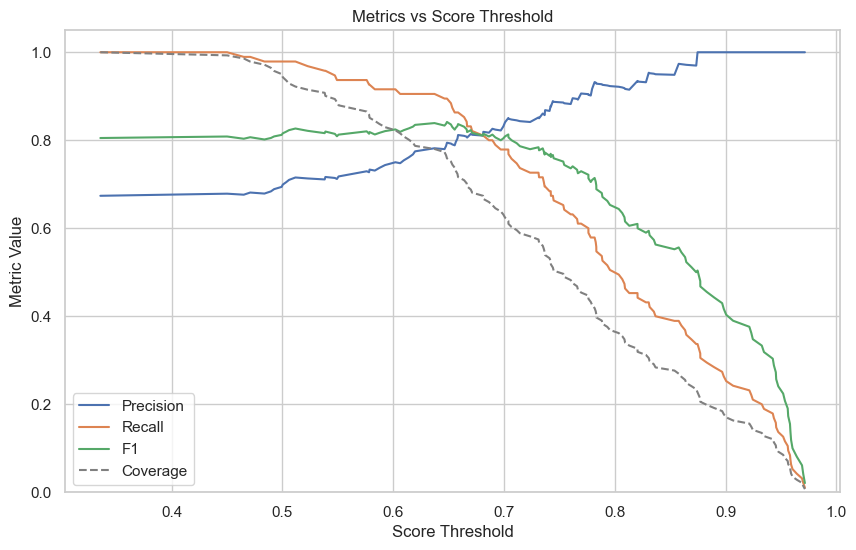

Best thresholds by metric:
precision: threshold=0.8747167587280273, value=1.0000
recall: threshold=0.3356184563409368, value=1.0000
f1: threshold=0.6484985174538472, value=0.8416
coverage: threshold=0.3356184563409368, value=1.0000


In [ ]:
df_sorted = embedding_top_1_df.sort_values("score").reset_index(drop=True)
thresholds = df_sorted["score"].tolist()

best_thresholds = {
    "precision": {"threshold": None, "value": -1},
    "recall": {"threshold": None, "value": -1},
    "f1": {"threshold": None, "value": -1},
    # "accuracy": {"threshold": None, "value": -1},
    "coverage": {"threshold": None, "value": -1},
}

metrics = []
for t in thresholds:
    valid = df_sorted["score"] >= t
    TP = ((valid) & (df_sorted["correct"])).sum()
    FP = ((valid) & (~df_sorted["correct"])).sum()
    FN = ((~valid) & (df_sorted["correct"])).sum()
    # FN = (~valid).sum()

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = (
        (2 * precision * recall / (precision + recall))
        if (precision + recall) > 0
        else 0
    )
    coverage = valid.mean()

    if precision > best_thresholds["precision"]["value"]:
        best_thresholds["precision"] = {"threshold": t, "value": precision}
    if recall > best_thresholds["recall"]["value"]:
        best_thresholds["recall"] = {"threshold": t, "value": recall}
    if f1 > best_thresholds["f1"]["value"]:
        best_thresholds["f1"] = {"threshold": t, "value": f1}
    # if accuracy > best_thresholds["accuracy"]["value"]:
    #     best_thresholds["accuracy"] = {"threshold": t, "value": accuracy}
    if coverage > best_thresholds["coverage"]["value"]:
        best_thresholds["coverage"] = {"threshold": t, "value": coverage}

    metrics.append(
        {
            "score": t,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            # "accuracy": accuracy,
            "coverage": coverage,
        }
    )

metrics_df = pd.DataFrame(metrics)

# Plot metrics vs score
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["score"], metrics_df["precision"], label="Precision")
plt.plot(metrics_df["score"], metrics_df["recall"], label="Recall")
plt.plot(metrics_df["score"], metrics_df["f1"], label="F1")
plt.plot(
    metrics_df["score"],
    metrics_df["coverage"],
    label="Coverage",
    linestyle="--",
    color="gray",
)

plt.xlabel("Score Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Score Threshold")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)
plt.show()

# Show best thresholds
print("Best thresholds by metric:")
for metric, data in best_thresholds.items():
    print(f"{metric}: threshold={data['threshold']}, value={data['value']:.4f}")

### This should match the highest f1 value we got in tuning:

In [90]:
df, metrics = evaluate_api(
    endpoint="http://127.0.0.1:8000/match/embedding",
    params={"limit": 1, "embedding_score_threshold": 0.6484985174538472},
    eval_data=eval_df,
)
print(metrics)

{'precision': 0.794392523364486, 'recall': 0.8947368421052632, 'f1': 0.8415841584158417, 'coverage': 0.7588652482269503}


# Embedding + Fuzzy Weight Tuning

In [96]:
weight_steps = [round(x, 1) for x in list([i / 10 for i in range(0, 11)])]  # 0.1 to 0.9
results = []

for embedding_weight in weight_steps:
    fuzzy_weight = round(1 - embedding_weight, 1)

    predictions_df, metrics = evaluate_api(
        endpoint=f"{API_BASE}/match/embedding_fuzzy",
        params={
            "limit": 1,
            "embedding_score_weight": embedding_weight,
            "fuzzy_score_weight": fuzzy_weight,
            "embedding_score_threshold": 0.6484985174538472,
        },
        eval_data=eval_df,
    )

    results.append(
        {
            "embedding_weight": embedding_weight,
            "fuzzy_weight": fuzzy_weight,
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"],
            "coverage": metrics["coverage"],
        }
    )
    print(f"Weights (E={embedding_weight}, F={fuzzy_weight}) → F1={metrics['f1']:.4f}")

results_df = pd.DataFrame(results)

Weights (E=0.0, F=1.0) → F1=0.8876
Weights (E=0.1, F=0.9) → F1=0.8652
Weights (E=0.2, F=0.8) → F1=0.8587
Weights (E=0.3, F=0.7) → F1=0.8526
Weights (E=0.4, F=0.6) → F1=0.8601
Weights (E=0.5, F=0.5) → F1=0.8543
Weights (E=0.6, F=0.4) → F1=0.8500
Weights (E=0.7, F=0.3) → F1=0.8515
Weights (E=0.8, F=0.2) → F1=0.8416
Weights (E=0.9, F=0.1) → F1=0.8416
Weights (E=1.0, F=0.0) → F1=0.8416


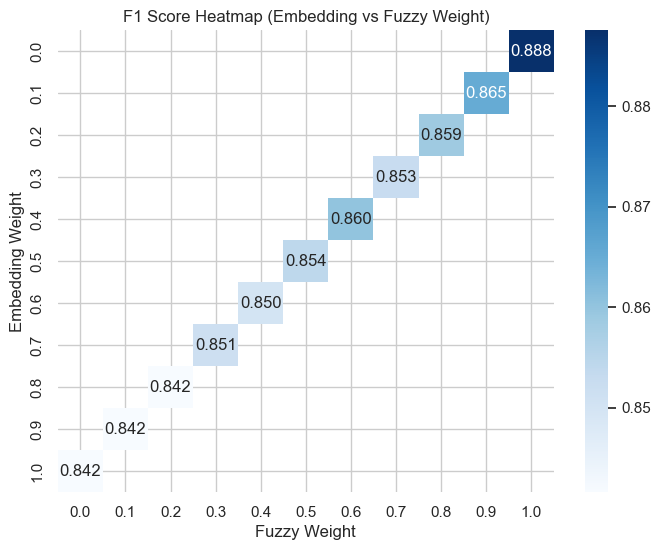

Best Combination:
embedding_weight    0.000000
fuzzy_weight        1.000000
precision           0.833333
recall              0.949367
f1                  0.887574
coverage            0.638298
Name: 0, dtype: float64


In [67]:
best_row = results_df.sort_values("f1", ascending=False).iloc[0]

pivot_df = results_df.pivot(
    index="embedding_weight", columns="fuzzy_weight", values="f1"
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="Blues")
plt.title("F1 Score Heatmap (Embedding vs Fuzzy Weight)")
plt.xlabel("Fuzzy Weight")
plt.ylabel("Embedding Weight")
plt.show()

print("Best Combination:")
print(best_row)

In [95]:
pure_fuzzy, metrics = evaluate_api(
    endpoint=f"{API_BASE}/match/embedding_fuzzy",
    params={
        "limit": 1,
        "embedding_score_weight": 0,
        "fuzzy_score_weight": 1,
        "embedding_score_threshold": 0.6484985174538472,
    },
    eval_data=eval_df,
    verbose_df=True,
)
print(metrics)
pure_fuzzy

{'precision': 0.8333333333333334, 'recall': 0.9493670886075949, 'f1': 0.8875739644970415, 'coverage': 0.6382978723404256}


,input,expected,predicted,score,correct
0,software dev,Software Developers,Software Developers,0.857693,True
1,java programmer,Computer Programmers,Computer Programmers,0.711456,True
2,data scientist,Data Scientists,Data Scientists,0.958146,True
3,cybersecurity analyst,Information Security Analysts,Information Security Analysts,0.795615,True
4,mechanical engineer,Mechanical Engineers,Mechanical Engineers,0.971608,True
...,...,...,...,...,...
136,florist,Floral Designers,Floral Designers,0.671231,True
137,baker,Bakers,Bakers,0.875912,True
138,pastry chef,Chefs and Head Cooks,"Chemistry Teachers, Postsecondary",0.167314,False
139,butcher,Butchers and Meat Cutters,Butchers and Meat Cutters,0.735923,True


# Cascade Evaluation

In [92]:
weight_steps = [round(x, 1) for x in list([i / 10 for i in range(0, 11)])]  # 0.1 to 0.9
results = []

for embedding_weight in weight_steps:
    fuzzy_weight = round(1 - embedding_weight, 1)

    predictions_df, metrics = evaluate_api(
        endpoint=f"{API_BASE}/match/cascade",
        params={
            "limit": 1,
            "embedding_score_weight": embedding_weight,
            "fuzzy_score_weight": fuzzy_weight,
            "embedding_score_threshold": 0.6484985174538472,
        },
        eval_data=eval_df,
    )

    results.append(
        {
            "embedding_weight": embedding_weight,
            "fuzzy_weight": fuzzy_weight,
            "precision": metrics["precision"],
            "recall": metrics["recall"],
            "f1": metrics["f1"],
            "coverage": metrics["coverage"],
        }
    )
    print(f"Weights (E={embedding_weight}, F={fuzzy_weight}) → F1={metrics['f1']:.4f}")

results_df = pd.DataFrame(results)

Weights (E=0.0, F=1.0) → F1=0.6486
Weights (E=0.1, F=0.9) → F1=0.6452
Weights (E=0.2, F=0.8) → F1=0.6417
Weights (E=0.3, F=0.7) → F1=0.6455
Weights (E=0.4, F=0.6) → F1=0.6455
Weights (E=0.5, F=0.5) → F1=0.6455
Weights (E=0.6, F=0.4) → F1=0.6455
Weights (E=0.7, F=0.3) → F1=0.6455
Weights (E=0.8, F=0.2) → F1=0.6526
Weights (E=0.9, F=0.1) → F1=0.6526
Weights (E=1.0, F=0.0) → F1=0.6597


In [94]:
pure_cascade_df, metrics = evaluate_api(
    endpoint="http://127.0.0.1:8000/match/cascade",
    params={
        "limit": 1,
        "embedding_score_weight": 1,
        "fuzzy_score_weight": 0,
        "embedding_score_threshold": 0.6484985174538472,
    },
    eval_data=eval_df,
    verbose_df=True,
)
print(metrics)
pure_cascade_df

{'precision': 0.8513513513513513, 'recall': 0.5384615384615384, 'f1': 0.6596858638743456, 'coverage': 0.524822695035461}


,input,expected,predicted,score,correct
0,software dev,Software Developers,Software Developers,0.857693,True
1,java programmer,Computer Programmers,Computer Programmers,0.711456,True
2,data scientist,Data Scientists,Data Scientists,0.958146,True
3,cybersecurity analyst,Information Security Analysts,Information Security Analysts,0.795615,True
4,mechanical engineer,Mechanical Engineers,Mechanical Engineers,0.971608,True
...,...,...,...,...,...
136,florist,Floral Designers,None,-inf,False
137,baker,Bakers,Bakers,0.875912,True
138,pastry chef,Chefs and Head Cooks,None,-inf,False
139,butcher,Butchers and Meat Cutters,None,-inf,False


# Finetuned model